# T5, Rouge and BertScore

The aim of the project is to explore how do models deal with text summarization, for example across a series of news articles.

The dataset selected for this task is the **CNN/DailyMail dataset**, a well-known English-language dataset containing over 300,000 unique news articles authored by journalists from CNN and the Daily Mail.

Among the various versions of this dataset, the version 2.0.0 is taken into consideration, as it is best suited to the nature and requirements of the task.

### Objective

The primary objective of this project is to understand the abstractive summarization capabilities of T5 model.

**Abstractive summarization** involves understanding the core meaning of a text and generating a concise, coherent summary that may include rephrased or newly generated content—not, simply extracted sentences.

**T5** (Text-to-Text Transfer Transformer) is an **encoder-decoder model** architecture that processes the input through an encoder and generates summaries via a decoder.

###Pipeline

Initially, the project will explore the **limitations of the pre-trained** T5 base model, a medium-sized model trained on a large corpus, which still shows difficulties on the given dataset.

Then, the focus will be on **training the base model** and trying to improve its performance, aiming to generate coherent and meaningful summaries.

To evaluate the model's performance on the task, the traditional **ROUGE metric**, which relies on exact token matches, will be used first, followed by **BERTScore**, a modern approach that leverages contextual embeddings from pre-trained language models (e.g., BERT, RoBERTa) to assess the semantic similarity between candidate and reference sentences.







---



## T5-base for text summarization

T5 (**Text-to-Text Transfer Transformer**) is a powerful model developed by Google; an encoder-decoder model based on the Transformer architecture.

It is pre-trained on a large corpus (called C4) using a denoising objective, then fine-tuned on a wide range of text-to-text tasks including translation, summarization, question answering, and classification.

In this project we will exploit T5 summarization capabilities


In [3]:
!pip install -U transformers
!pip install -U datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install rouge_score
!pip install transformers safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [4]:
import torch
import pprint
import evaluate
import numpy as np

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

# Load the dataset

In [5]:
# Load data
train_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:5000]")
test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5000]")
val_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation[:1000]")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

  Let's see the shape of the train, test and validation dataset:

  * train set : 5000 articles
  * validation set : 1000 articles
  * test set : 5000 articles

In [6]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 5000
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1000
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 5000
})


# Dataset Exploratory Analysis

To better understand the dataset taken into consideration it may be useful to verify the lengths of the text included

In [12]:
# Find the longest article and summary in the entire training set.

def find_longest_length(dataset,n1,n2,n3):
    max_length = 0
    counter1 = 0
    counter2 = 0
    counter3= 0
    for text in dataset:
        corpus = [
            word for word in text.split()
        ]

        if len(corpus) > n1:
            counter1 += 1
        if len(corpus) > n2:
            counter2 += 1
        if len(corpus) > n3:
            counter3 += 1
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length, counter1, counter2, counter3


In [13]:
# Find the longest article
n1= 1500
n2= 1000
n3= 500

longest_article_length, counter1, counter2, counter3 = find_longest_length(train_dataset['article'], n1, n2 , n3 )
print(f"Longest article length: {longest_article_length} words")
print(f"Artciles larger than {n1} words: {counter1}")
print(f"Artciles larger than {n2} words: {counter2}")
print(f"Artciles larger than {n3} words: {counter3}")


Longest article length: 1831 words
Artciles larger than 1500 words: 35
Artciles larger than 1000 words: 580
Artciles larger than 500 words: 2918


In [14]:
# Find the longest summary
n1= 50
n2= 25
n3= 15

longest_article_length, counter1, counter2, counter3 = find_longest_length(train_dataset['highlights'], n1, n2 , n3 )
print(f"Longest summary length: {longest_article_length} words")
print(f"Artciles larger than {n1} words: {counter1}")
print(f"Artciles larger than {n2} words: {counter2}")
print(f"Artciles larger than {n3} words: {counter3}")


Longest summary length: 75 words
Artciles larger than 50 words: 1091
Artciles larger than 25 words: 4981
Artciles larger than 15 words: 4996


Let's find also the average legth of articles and summaries

In [15]:
# Find the average sentence length in the entire training set

def find_avg_sentence_length(dataset):

    sentence_lengths = []
    for text in dataset:
        corpus = [
            word for word in text.split()
        ]
        sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

avg_article_length = find_avg_sentence_length(train_dataset['article'])
print(f"Average article length: {avg_article_length} words")

avg_summary_length = find_avg_sentence_length(train_dataset['highlights'])
print(f"Averrage summary length: {avg_summary_length} words")

Average article length: 615.2142 words
Averrage summary length: 43.8888 words


This is the actual shape of the articles in the dataset

In [39]:
print("This is the first article in the dataset: \n")
print(train_dataset['article'][0])
print("\nThis is the summary of the first article: \n")
print(train_dataset['highlights'][0])

# Will be useful later
ref1=train_dataset['highlights'][0]
ref2=train_dataset['highlights'][1]
ref3=train_dataset['highlights'][2]

# for final comparison REMOVE
# ref4=train_dataset['highlights'][3]
# ref5=train_dataset['highlights'][4]

# shape improvement
val1=val_dataset['highlights'][0]
val2=val_dataset['article'][1]


This is the first article in the dataset: 

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movi

WORDS COUNT

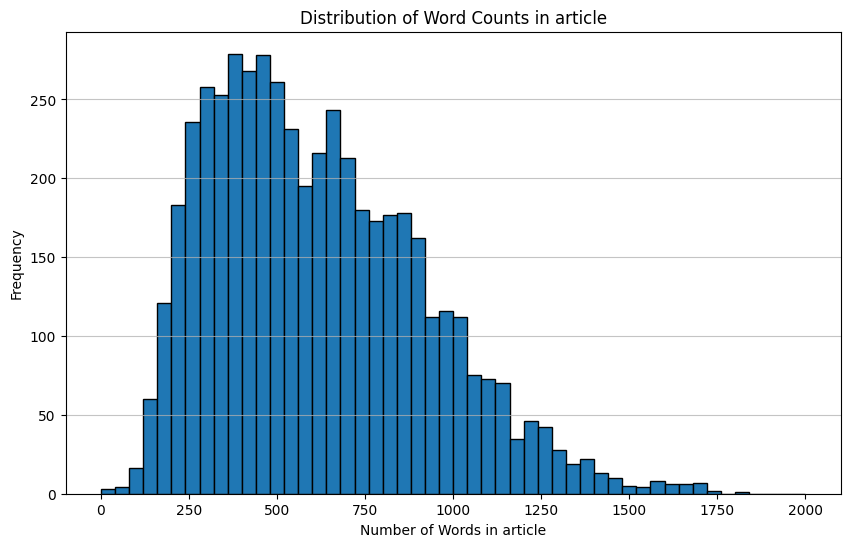

In [17]:
# PLOT THE DISTRIBUTION OF WORDS IN  ARTICLES

import matplotlib.pyplot as plt

def plot_word_distribution(dataset, text_key):

  word_counts = [len(text.split()) for text in dataset[text_key]]

  plt.figure(figsize=(10, 6))
  plt.hist(word_counts, bins=50, range=(0, 2000), edgecolor='black') # Adjust bins and range as needed
  plt.xlabel(f'Number of Words in {text_key}')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Word Counts in {text_key}')
  plt.grid(axis='y', alpha=0.75)
  plt.show()

# Plot the distribution for articles
plot_word_distribution(train_dataset, 'article')


ZIPF'S LAW

Valuable insights can be given by the distribution of words across articles; it is expected that this distribution will follow **Zipf’s Law**, meaning that a few words will occur very frequently while most words will appear rarely.

This reflects the natural linguistic phenomenon where common words such as stopwords ("the," "and," "is") dominate the text, whereas specialized or rare terms appear infrequently.



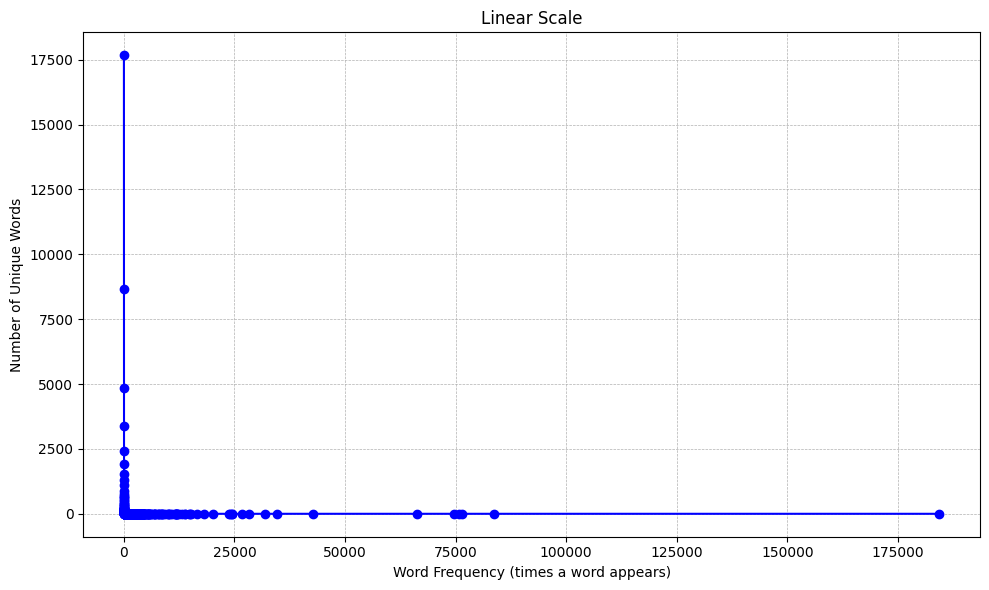

In [19]:
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

all_text = ' '.join(train_dataset['article'])
# quick tokenization and cleaning
words = re.findall(r'\b\w+\b', all_text.lower())
word_counts = Counter(words)

frequency_distribution = defaultdict(int)
for word, freq in word_counts.items():
    frequency_distribution[freq] += 1

freqs = sorted(frequency_distribution.items()) # sorting
x, y = zip(*freqs)

# Linear scale
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.title("Linear Scale")
plt.xlabel("Word Frequency (times a word appears)")
plt.ylabel("Number of Unique Words")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()



The graph shows that the majority of words in the article text appear between 0 and 25,000 times, while only a limited number of words, probably functional words, appear more than 60,000 times.



Indeed the most common word is "the"

In [20]:
most_common_word, frequency = word_counts.most_common(1)[0]

print(f"The most frequent word is '{most_common_word}' which appears {frequency} times.")


The most frequent word is 'the' which appears 184330 times.


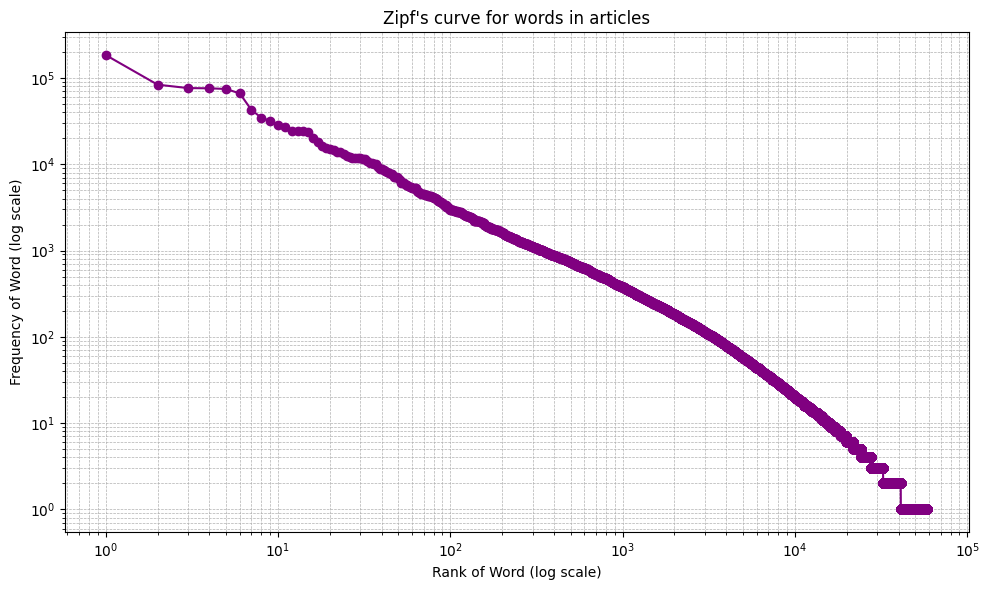

In [21]:
# PLOT ZIPF'S CURVE
all_text = ' '.join(train_dataset['article'])
words = re.findall(r'\b\w+\b', all_text.lower())
word_counts = Counter(words)
frequencies = sorted(word_counts.values(), reverse=True)

ranks = range(1, len(frequencies) + 1) # Generate ranks

# Zipf's Law: Frequency vs Rank
plt.figure(figsize=(10, 6))
plt.plot(ranks, frequencies, marker='o', linestyle='-', color='purple')
plt.xscale('log')
plt.yscale('log')
plt.title("Zipf's curve for words in articles")
plt.xlabel("Rank of Word (log scale)")
plt.ylabel("Frequency of Word (log scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


WORD CLOUD

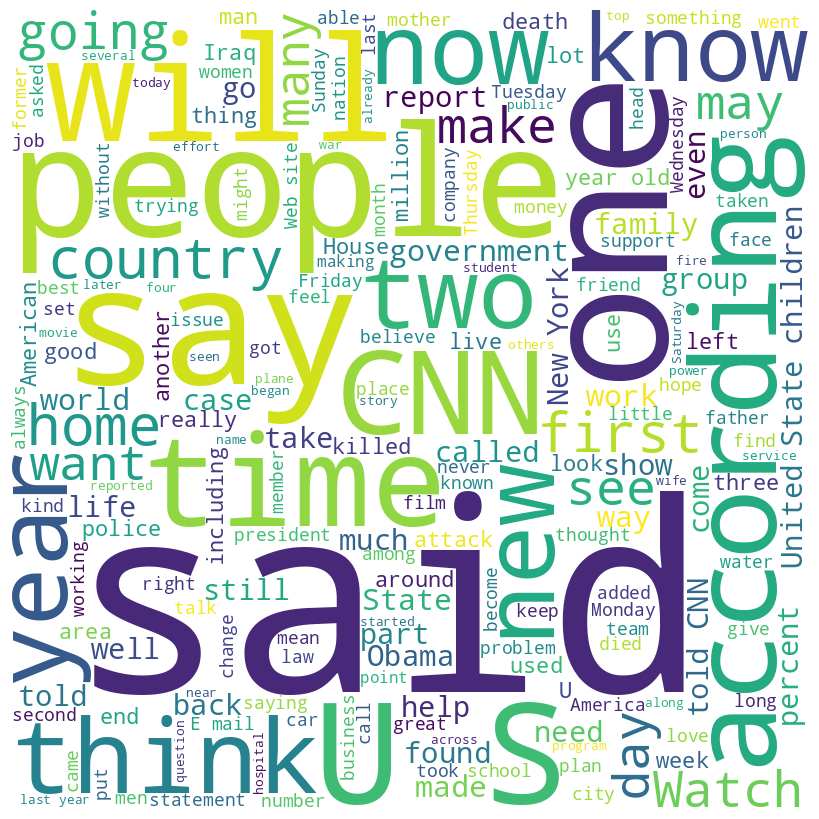

In [24]:
# word cloud
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

all_articles_text = " ".join(train_dataset['article'])

generate_wordcloud(all_articles_text)

# Import a Pre-Trained Model

Load the model from the trasformers library.


In [25]:
# MODEL'S CONFIGURATION
MODEL = 't5-base'
BATCH_SIZE = 4
EPOCHS = 5
NUM_PROCS = 4
OUT_DIR = 'results_t5base'
MAX_LENGTH = 384

In [26]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro



The T5 Base model contains around **223 million parameters**.

It may look like a large model but it performances are much better compared to the T5 Small model.

In [27]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

222,903,552 total parameters.
222,903,552 training parameters.


The imported **pre-trained model** will serve as the base model and be treated as a **baseline**.

The goal  is to improve its performance by enhancing its ability to generate coherent and meaningful summaries of the articles.

# Pre processing

T5 encodes words by first splitting them into **subword token**s using the SentencePiece tokenizer (included in T5Tokenizer).

Each subword token is then converted into an **integer ID** using a fixed vocabulary.

These IDs are mapped to dense embeddings, which are then processed by the model during task execution

In [28]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)

def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['article']]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    targets = [summary for summary in examples['highlights']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=MAX_LENGTH,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Once defined the function that perform the preprocessing steps we can apply it to both validation and train dataset

In [29]:
# Tokenize train and validation set
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)
tokenized_valid = val_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Each article in the dataset is now associated also to an input_ids, a label and an attention mask

In [30]:
# column names
print(tokenized_train.column_names)

['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels']


In [31]:
tokenized_train[0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

# Generate the first summaries

As all the pre requisite have been declare the first summaries can be generated

FIRST ARTICLE - Actor Daniel Radcliffe

In [32]:
input_ids_list = tokenized_train[0]["input_ids"]
input_ids_tensor = torch.tensor([input_ids_list]).to(device)

# Generate Summary 1
summary_ids = model.generate(
    input_ids_tensor,
    max_length=75,
    min_length=40,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Article:")
print(train_dataset['article'][0])
print("\nGenerated Summary (T5 Base):")
print(summary)
print("\nReference Summary:")
print(ref1)

Original Article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

SECOND ARTICLE - The forgotten floor

In [33]:
input_ids_list = tokenized_train[1]["input_ids"]
input_ids_tensor = torch.tensor([input_ids_list]).to(device)

# Generate Summary 2
summary_ids = model.generate(
    input_ids_tensor,
    max_length=75,
    min_length=40,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Article:")
print(train_dataset['article'][1])
print("\nGenerated Summary (T5 Base):")
print(summary)
print("\nReference Summary:")
print(ref2)

Original Article:
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

THIRD ARTICLE - Minnesota bridge collapse

In [34]:
input_ids_list = tokenized_train[2]["input_ids"]
input_ids_tensor = torch.tensor([input_ids_list]).to(device)

# Generate Summary 3
summary_ids = model.generate(
    input_ids_tensor,
    max_length=75,
    min_length=40,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Article:")
print(train_dataset['article'][2])
print("\nGenerated Summary (T5 Base):")
print(summary)
print("\nReference Summary:")
print(ref3)

Original Article:
MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to the other just completely gave way, fell all the way down," survivor Gary Babineau told CNN. "I probably had a 30-, 35-foot free fall. And there's cars in the water, there's cars on fire. The whole bridge is down." He said his back was injured but he determined he could move around. "I realized there was a school bus right next to me, and me and a couple of other guys went over and started lifting the kids off the bridge. They were yelling, screaming, bleeding. I think there were some broken bones."  Watch a driver describe his narrow escape » . At home when he heard about the disaster, Dr. John Hink, an emergency room physician, jumped into his car and rushed to the scene in 15 minutes. He arrived at the south side of the bridge, stood on the riverbank and saw dozens of people lying dazed 

### CONSIDERATION



* Comparing the length of the summaries generated by the model and the references, no consistent discrepancy can be observed; **the model produces summaries of adequate length.**
* Regarding punctuation marks and the use of lowercase/uppercase letters, the model seems **not to handle them correctly**, which may be due to the fact that the model has not yet been fully refined.
* Indeed, the model **captures the semantics** and is able to identify the most important chunks of information from the article, although it does not express them with fully correct grammar.



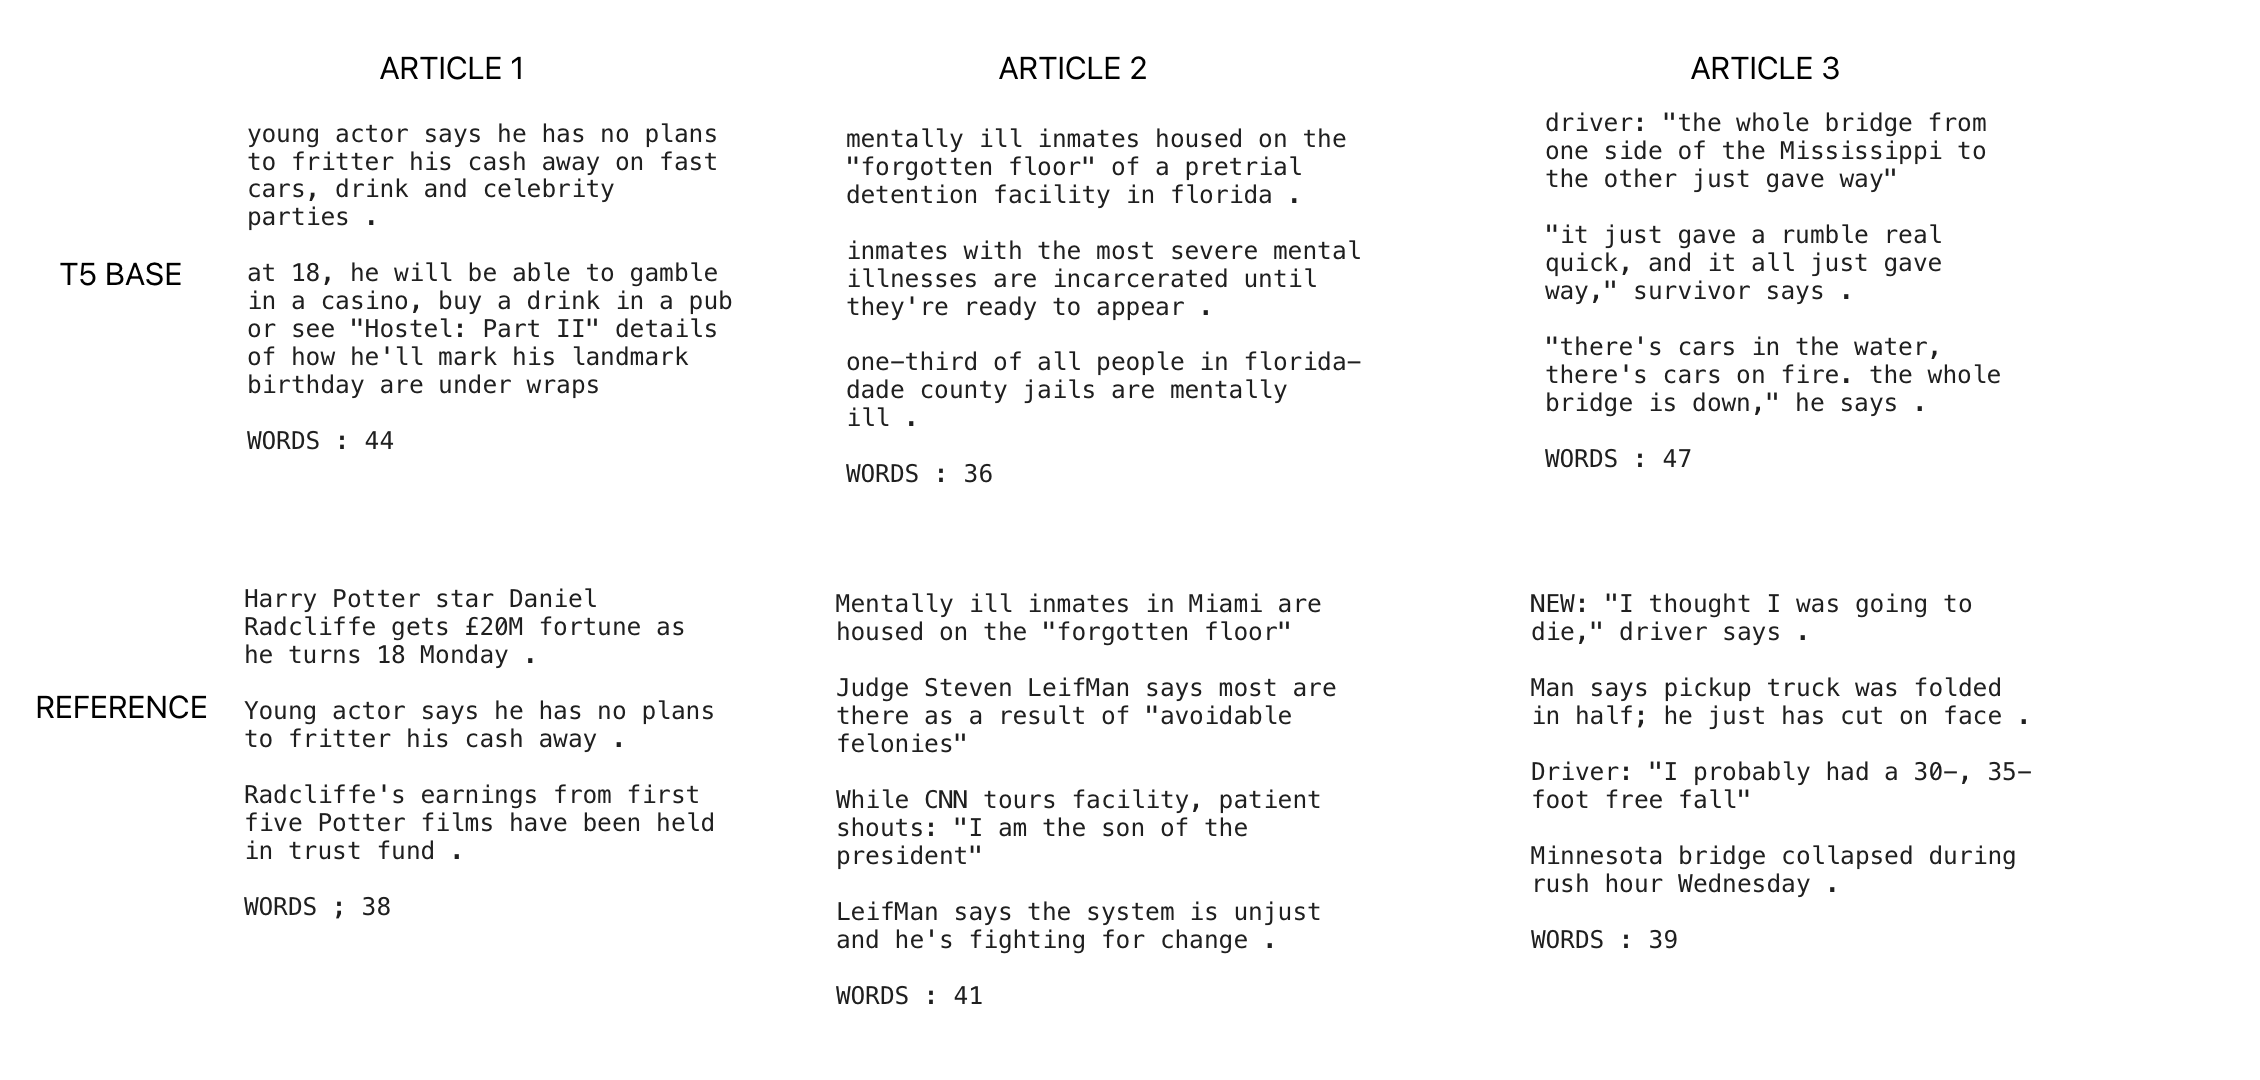

# Evaluate base model's capabilities

## ROUGE SCORE

To evaluate the initial model outputs we will use ROUGE SCORE, Recall-Oriented Understudy for Gisting Evaluation is a set of metrics used to evaluate the quality of automatic text summaries by comparing them to human-written reference summaries.

ROUGE measures the overlap between the generated summary and the reference summary using various techniques like n-gram matching, word sequences, and word pairs.

* ROUGE-1	= measure the overlap of unigrams, so count how many individual words are in common

* ROUGE-2	= measure the overlap of bigrams, so captures fluency and basic phrase matching

* ROUGE-L: a score defined by the longest matching sequence between the prediction and the ground truth.

In [43]:
# define the function to evaluate model's rouge score

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=[
            'rouge1',
            'rouge2',
            'rougeL'
        ]
    )

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In order to avoid memory problems in the Trainer it can be insert a workaround (function) to limit the number of tensors stored and preserve only on the most relevant

In [44]:
def preprocess_logits_for_metrics(logits, labels):

    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

In [ ]:
# EVALUATE T5-BASE WITH ROUGE SCORE

training_args1 = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    eval_strategy='steps',
    eval_steps=200,
    report_to='tensorboard',
)

trainer1 = Trainer(
    model=model,
    args=training_args1,
    eval_dataset=tokenized_train,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

results = trainer1.evaluate() # 3 minutes with T4 GPU
print(results)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'eval_loss': 14.347864151000977, 'eval_model_preparation_time': 0.0498, 'eval_rouge1': 0.2827, 'eval_rouge2': 0.1503, 'eval_rougeL': 0.2632, 'eval_gen_len': 384.0, 'eval_runtime': 708.2137, 'eval_samples_per_second': 7.06, 'eval_steps_per_second': 1.765}




```
T5-base evaluation with Rouge score
  'eval_rouge1': 0.2817,
  'eval_rouge2': 0.1351,
  'eval_rougeL': 0.2595,
  'eval_gen_len': 512.0,
  'eval_runtime': 183.12,
  'eval_samples_per_second': 5.461,
  'eval_steps_per_second': 1.365
```



The initial model has moderate performance; it seems to capture some content but it **isn’t very precise or fluent** yet

In particular:

* `eval_rouge1: 0.2817` :  28% overlap in individual words, lots of **key terms are misrepresenting **
* `eval_rouge2: 0.1351` : this value is close to 0, meaning that the model captures few phrase-level similarity but **struggles to generate fluent or accurate word sequences matching the references**.

The model may not be well optimized or could benefit from **more training** or hyperparameter tuning.

## BERTScore

BERTScore evaluates how similar the meanings of words are by using cosine similarity between contextual embeddings.
These embeddings are generated using a pre-trained language model such as BERT, and then the embeddings of the predicted words and the reference words are compared using cosine similarity.

Based on these similarity scores, precision, recall, and F1-score are computed:

* precision : is the model’s output semantically similar to parts of the reference?
$$\text{Precision} = \frac{1}{n} \sum_{i=1}^{n} \max_j \cos(x_i, y_j$$
* recall → is most of the reference’s meaning captured by the candidate?
$$\text{Recall} = \frac{1}{m} \sum_{j=1}^{m} \max_i \cos(x_i, y_j)$$

* F1-score →  semantic alignment in both directions.

In [45]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


In [46]:
import bert_score

def compute_metrics2(eval_pred):

    # decode predictions
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    P, R, F1 = bert_score.score(
        decoded_preds,
        decoded_labels,
        lang='en',
        model_type='bert-base-uncased',
        rescale_with_baseline=True,
        verbose=False
    )

    return {
        "bertscore_precision": P.mean().item(),
        "bertscore_recall": R.mean().item(),
        "bertscore_f1": F1.mean().item()
    }


In [47]:
def preprocess_logits_for_metrics2(logits, labels):

    if isinstance(logits, tuple):
        # Depending on the model's output, logits might be a tuple
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids



In [ ]:
# EVALAUTE T5-BASE WITH BERSCORE

training_args2 = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    eval_strategy='steps',
    eval_steps=200,
    report_to='tensorboard'
)

trainer2 = Trainer(
    model=model,
    args=training_args2,
    eval_dataset=tokenized_train,
    compute_metrics=compute_metrics2,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics2
)

results = trainer2.evaluate() # 3 minutes with T4 GPU
print(results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

{'eval_loss': 14.347864151000977, 'eval_model_preparation_time': 0.0366, 'eval_bertscore_precision': 0.057501133531332016, 'eval_bertscore_recall': 0.43166404962539673, 'eval_bertscore_f1': 0.18572579324245453, 'eval_runtime': 797.1432, 'eval_samples_per_second': 6.272, 'eval_steps_per_second': 1.568}



```
T5-BASE evaluation BERTScore
'eval_model_preparation_time': 0.005
'eval_bertscore_precision': 0.06287330389022827
'eval_bertscore_recall': 0.37231653928756714
'eval_bertscore_f1': 0.16506297886371613
'eval_runtime': 160.8465
'eval_samples_per_second': 6.217
'eval_steps_per_second': 3.109

```



In the context of BertScore  the meaningful values to take into consideration are :

* `eval_bertscore_precision: 0.062` , only the 6% of the generated content is semantically relevant (compared to reference)


* `eval_bertscore_recall: 0.37 `,  the 37% of the reference meaning is covered in the prediction

* `eval_bertscore_f1: 0.165`, this is the main metric to consider, it is relatively low, meaning the **generated outputs are not strongly aligned semantically with the references**.

#  Fine Tuning

The overall performance, measured by both ROUGE and BERTScore, is unsatisfactory.

To improve the quality of the generated summaries, **fine-tuning the pre-trained T5 base model can be a useful strategy**, particularly given the relatively small size of the dataset.

In [ ]:
training_args3 = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    gradient_accumulation_steps = 2,
    logging_dir=OUT_DIR,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps= 625,
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    learning_rate=0.0001,
    dataloader_num_workers=2,
    fp16=True
)


The model will be evaluated every 625 steps, the batch size and the epoches have been previously defined



```
# MODEL'S CONFIGURATION
MODEL = 't5-base'
BATCH_SIZE = 4
EPOCHS = 5
OUT_DIR = 'results_t5base'
MAX_LENGTH = 384
```



In [ ]:
# load final_model to skip
trainer3 = Trainer(
    model=model,
    args=training_args3,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics
)

history = trainer3.train() # 55 minutes

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Gen Len
625,0.193200,0.271215,0.533100,0.270600,0.494200,50.191000
1250,0.223200,0.273832,0.530900,0.267400,0.491000,50.192000
1875,0.234500,0.268922,0.530700,0.267500,0.491800,50.191000
2500,0.219500,0.274322,0.528100,0.267000,0.489500,50.191000
3125,0.181300,0.276350,0.528000,0.267200,0.488600,50.191000


In [ ]:
model.save_pretrained("t5_final_model")
tokenizer.save_pretrained("t5_final_model")

('t5_final_model/tokenizer_config.json',
 't5_final_model/special_tokens_map.json',
 't5_final_model/spiece.model',
 't5_final_model/added_tokens.json')

# Shape Improvement

Firstly a concrete improvement of the produced output of the model can be highligthed.

The new summaries generated are grammatically correct but also make use of coherent and adeguate punctuation and upper/lower case

BASE T5 MODEL

In [35]:
t5_base_model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_base_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [36]:
input_ids_list = tokenized_valid[0]["input_ids"]
input_ids_tensor = torch.tensor([input_ids_list]).to(device)

# Generate Summary
summary_ids = t5_base_model.generate(
    input_ids_tensor,
    max_length=75,
    min_length=40,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Article:")
print(val_dataset['article'][0])
print("\nGenerated Summary (T5 Base):")
print(summary)
print("\nReference Summary:")
print(val1)

Original Article:
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacif

T5 TRAINED

In [37]:
### IMPORT THE TRAINED MODEL
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

model_path = "/content/drive/MyDrive/TXT/t5_final_model" # insert the path do the folder with the configuration of the final model

final_model = T5ForConditionalGeneration.from_pretrained(model_path)
final_tokenizer = T5Tokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

Mounted at /content/drive


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [40]:
input_ids_list = tokenized_valid[0]["input_ids"]
input_ids_tensor = torch.tensor([input_ids_list]).to(device)

# Generate Summary
summary_ids = final_model.generate(
    input_ids_tensor,
    max_length=75,
    min_length=40,
    num_beams=4,
    early_stopping=True
)

summary = final_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Article:")
print(val_dataset['article'][0])
print("\nGenerated Summary (T5 TRAINED):")
print(summary)
print("\nReference Summary:")
print(val1)

Original Article:
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacif

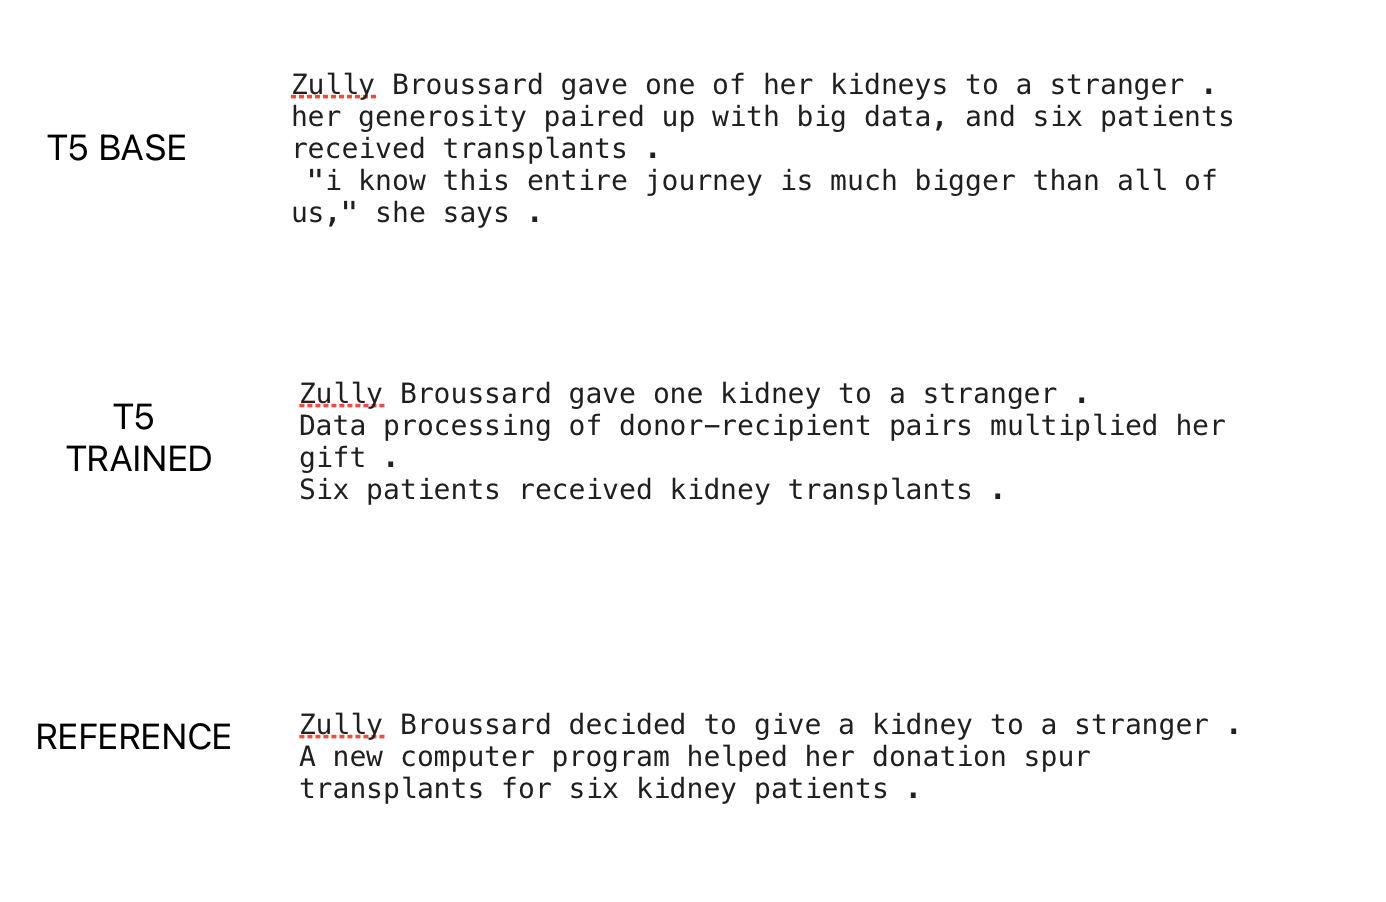

# Final Evaluation


After fine-tuning, the model can now be used to generate summaries for previously unseen articles.

This final evaluation is conducted on the test set to assess the model’s ability to generalize to new data.

In [41]:
# PRE PROCESS THE TEST DATASET
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

### IMPROVEMENT IN ROUGE SCORE

By re-evaluating the model using the ROUGE score, it is expected that the metric will yield higher values, reflecting improved summarization performance.

In [50]:
training_args5 = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    eval_strategy='steps',
    eval_steps=200,
    report_to='tensorboard',
)

trainer5 = Trainer(
    model=final_model, # upload the trained model
    args=training_args5,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

results = trainer5.evaluate() # 10 minutes with T4 GPU
print(results)

{'eval_loss': 0.43064776062965393, 'eval_model_preparation_time': 0.0046, 'eval_rouge1': 0.5754, 'eval_rouge2': 0.3061, 'eval_rougeL': 0.5315, 'eval_gen_len': 70.4954, 'eval_runtime': 594.8219, 'eval_samples_per_second': 8.406, 'eval_steps_per_second': 2.101}


### IMRPOVEMENT IN BERTSCORE

As seen for the rouge score it can be interesting analysing the improvement in BERTScore of the model, comparing performances before and after fine-tuning.



In [51]:
# EVALAUTE T5-BASE WITH BERSCORE

training_args2 = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    eval_strategy='steps',
    eval_steps=200,
    report_to='tensorboard'
)

trainer2 = Trainer(
    model=final_model, # upload the trained model
    args=training_args2,
    eval_dataset=tokenized_test ,
    compute_metrics=compute_metrics2,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics2
)

results = trainer2.evaluate() # 10 minutes with T4 GPU
print(results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

{'eval_loss': 0.43064776062965393, 'eval_model_preparation_time': 0.0046, 'eval_bertscore_precision': 0.5166292190551758, 'eval_bertscore_recall': 0.5430012345314026, 'eval_bertscore_f1': 0.5304966568946838, 'eval_runtime': 683.0005, 'eval_samples_per_second': 7.321, 'eval_steps_per_second': 1.83}


# Conclusion

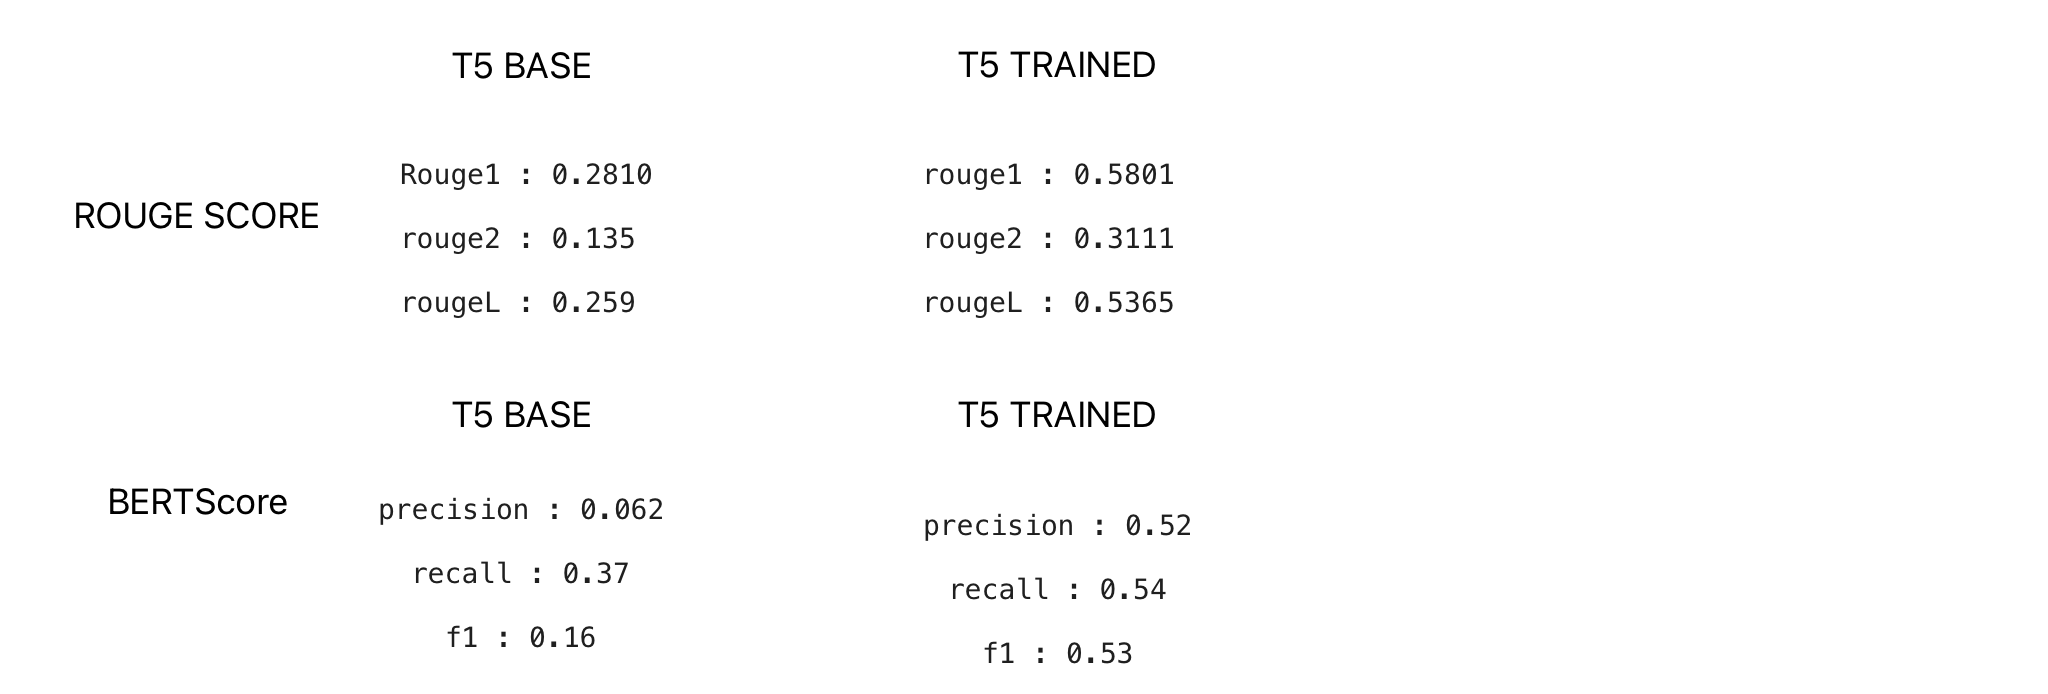

Although the model initially performed poorly across both evaluated metrics, the results **significantly improved following a phase of fine-tuning.**

Models such as T5, BERT, and GPT have been trained on vast amounts of textual data and are capable of performing a wide range of downstream tasks; their versatility lies in the fact that, even in their base form, they can generate outputs across a variety of use cases.

However, while pre-trained models provide a starting point, their outputs are not always suitable for direct deployment in domain-specific applications without further adaptation.



